In [13]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv', thousands=',')
test_data = pd.read_csv('Google_Stock_Price_Test.csv', thousands=',')

In [9]:
data = pd.concat([train_data, test_data])
data.reset_index(inplace=True, drop=True)
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1273,1/25/2017,829.62,835.77,825.06,835.67,1494500
1274,1/26/2017,837.81,838.00,827.01,832.15,2973900
1275,1/27/2017,834.71,841.95,820.44,823.31,2965800
1276,1/30/2017,814.66,815.84,799.80,802.32,3246600


Text(0, 0.5, 'Stock Price')

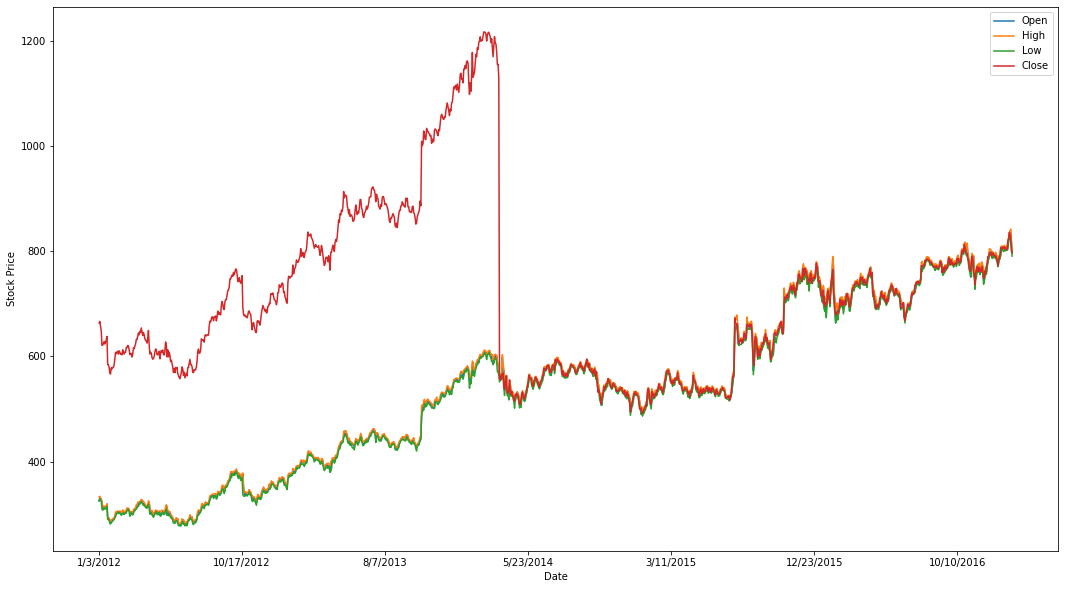

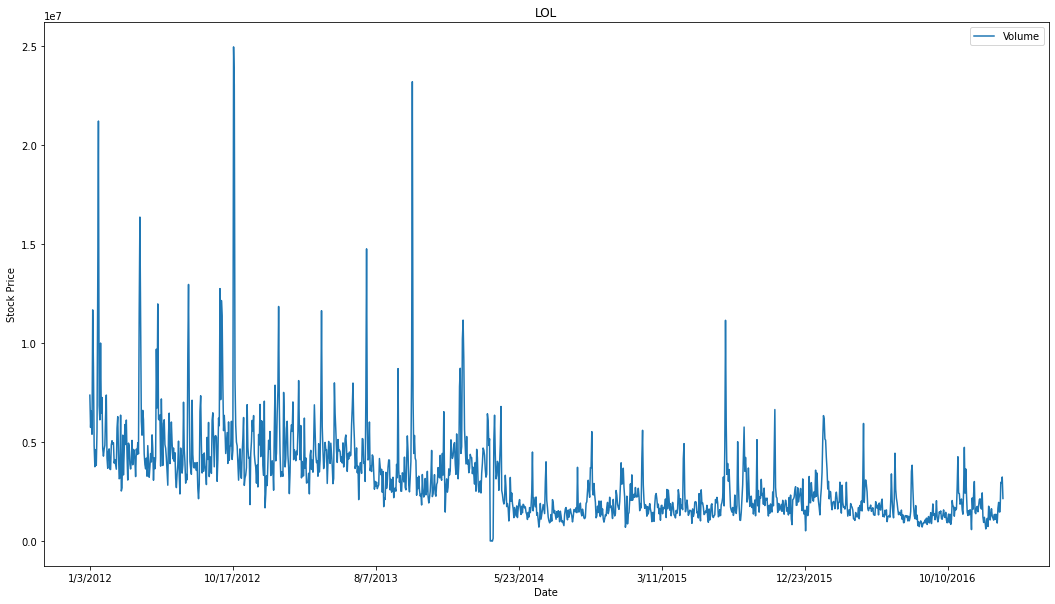

In [17]:
ax1 = data.plot(x='Date', y=['Open', 'High', 'Low', 'Close'], figsize=(18,10))
ax1.set_ylabel('Stock Price')

ax2 = data.plot(x='Date', y=['Volume'], figsize=(18,10), title = 'LOL')
ax2.set_ylabel('Stock Price')

In [20]:
data_wo_date = data[['Open', 'Close', 'High', 'Low','Volume']]
data_wo_date

,Open,Close,High,Low,Volume
0,325.25,663.59,332.83,324.97,7380500
1,331.27,666.45,333.87,329.08,5749400
2,329.83,657.21,330.75,326.89,6590300
3,328.34,648.24,328.77,323.68,5405900
4,322.04,620.76,322.29,309.46,11688800
...,...,...,...,...,...
1273,829.62,835.67,835.77,825.06,1494500
1274,837.81,832.15,838.00,827.01,2973900
1275,834.71,823.31,841.95,820.44,2965800
1276,814.66,802.32,815.84,799.80,3246600


In [21]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_wo_date))
data_scaled

,0,1,2,3,4
0,0.082568,0.237573,0.092057,0.086851,0.295258
1,0.093343,0.241514,0.093912,0.094327,0.229936
2,0.090766,0.228781,0.088348,0.090344,0.263612
3,0.088099,0.216419,0.084816,0.084505,0.216179
4,0.076823,0.178548,0.073260,0.058641,0.467797
...,...,...,...,...,...
1273,0.985341,0.474719,0.988979,0.996453,0.059535
1274,1.000000,0.469868,0.992956,1.000000,0.118783
1275,0.994451,0.457685,1.000000,0.988050,0.118458
1276,0.958564,0.428758,0.953437,0.950508,0.129704


<AxesSubplot:>

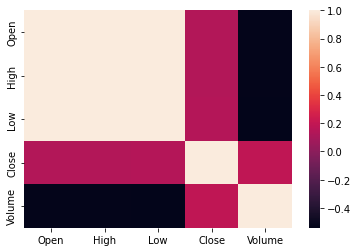

In [27]:
import seaborn as sns

sns.heatmap(data.corr())

In [44]:
data = data_scaled[[2,4]]

In [45]:
data

,2,4
0,0.092057,0.295258
1,0.093912,0.229936
2,0.088348,0.263612
3,0.084816,0.216179
4,0.073260,0.467797
...,...,...
1273,0.988979,0.059535
1274,0.992956,0.118783
1275,1.000000,0.118458
1276,0.953437,0.129704


In [46]:
def split_with_timesteps(sequence, n_past, n_future):
    x = [] #past observations
    y = [] #future observations
    
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end>len(sequence):
            break
            
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)
        
    return np.array(x),np.array(y)

In [47]:
data = data.to_numpy()

In [48]:
n_steps = 60
X,y = split_with_timesteps(data, n_steps, 1)

In [49]:
print(X.shape, y.shape)

(1218, 60, 2) (1218, 1)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=50)

In [52]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(300, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

In [53]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [54]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
31/31 - 6s - loss: 0.0128 - mae: 0.0777 - val_loss: 0.0064 - val_mae: 0.0485 - 6s/epoch - 192ms/step
Epoch 2/100
31/31 - 1s - loss: 0.0051 - mae: 0.0422 - val_loss: 0.0058 - val_mae: 0.0427 - 603ms/epoch - 19ms/step
Epoch 3/100
31/31 - 1s - loss: 0.0049 - mae: 0.0391 - val_loss: 0.0046 - val_mae: 0.0358 - 588ms/epoch - 19ms/step
Epoch 4/100
31/31 - 1s - loss: 0.0048 - mae: 0.0389 - val_loss: 0.0044 - val_mae: 0.0367 - 592ms/epoch - 19ms/step
Epoch 5/100
31/31 - 1s - loss: 0.0047 - mae: 0.0378 - val_loss: 0.0046 - val_mae: 0.0391 - 609ms/epoch - 20ms/step
Epoch 6/100
31/31 - 1s - loss: 0.0046 - mae: 0.0374 - val_loss: 0.0046 - val_mae: 0.0388 - 583ms/epoch - 19ms/step
Epoch 7/100
31/31 - 1s - loss: 0.0046 - mae: 0.0378 - val_loss: 0.0046 - val_mae: 0.0377 - 588ms/epoch - 19ms/step
Epoch 8/100
31/31 - 1s - loss: 0.0045 - mae: 0.0368 - val_loss: 0.0047 - val_mae: 0.0380 - 579ms/epoch - 19ms/step
Epoch 9/100
31/31 - 1s - loss: 0.0046 - mae: 0.0368 - val_loss: 0.0044 - val_mae: 

Epoch 72/100
31/31 - 1s - loss: 0.0034 - mae: 0.0315 - val_loss: 0.0030 - val_mae: 0.0333 - 606ms/epoch - 20ms/step
Epoch 73/100
31/31 - 1s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0030 - val_mae: 0.0325 - 602ms/epoch - 19ms/step
Epoch 74/100
31/31 - 1s - loss: 0.0034 - mae: 0.0322 - val_loss: 0.0031 - val_mae: 0.0305 - 601ms/epoch - 19ms/step
Epoch 75/100
31/31 - 1s - loss: 0.0034 - mae: 0.0315 - val_loss: 0.0030 - val_mae: 0.0343 - 601ms/epoch - 19ms/step
Epoch 76/100
31/31 - 1s - loss: 0.0034 - mae: 0.0319 - val_loss: 0.0030 - val_mae: 0.0326 - 601ms/epoch - 19ms/step
Epoch 77/100
31/31 - 1s - loss: 0.0034 - mae: 0.0323 - val_loss: 0.0029 - val_mae: 0.0311 - 598ms/epoch - 19ms/step
Epoch 78/100
31/31 - 1s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0030 - val_mae: 0.0321 - 599ms/epoch - 19ms/step
Epoch 79/100
31/31 - 1s - loss: 0.0034 - mae: 0.0321 - val_loss: 0.0029 - val_mae: 0.0318 - 608ms/epoch - 20ms/step
Epoch 80/100
31/31 - 1s - loss: 0.0034 - mae: 0.0319 - val_loss: 0.0030 

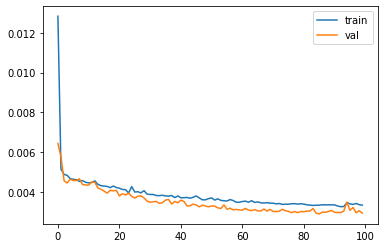

In [57]:
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()

In [58]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae)) 

MSE: 0.003, RMSE: 0.054, MAE: 0.031


In [59]:
# predicting y_test values
print(X_test.shape)
predicted_values = model.predict(X_test)
print(predicted_values.shape)
# print(predicted_values)

(244, 60, 2)
(244, 1)


<Figure size 720x432 with 0 Axes>

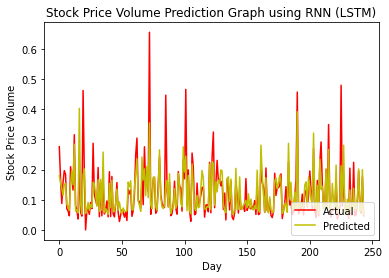

<Figure size 720x432 with 0 Axes>

In [60]:
plt.plot(y_test,c = 'r')
plt.plot(predicted_values,c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.figure(figsize=(10,6)) 

In [61]:
R_square = r2_score(y_test, predicted_values) 
 
print(R_square)

0.639294573960157


In [62]:
def split_with_time_steps(sequence, n_past, n_future):
    x, y = [],[]
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end>len(sequence):
            break
        
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:n_future, -1]
        x.append(past)
        y.append(future)
    
    return np.array(x),np.array(y)
        